# **Missing Data**

In real-world datasets, missing data is a common challenge that can significantly affect the performance of predictive models. The nature of missing data—whether it’s **Missing Completely at Random (MCAR)**, **Missing at Random (MAR)**, or **Missing Not at Random (MNAR)**—introduces unique challenges that require tailored imputation strategies to minimize bias and maintain predictive accuracy.  

This notebook aims to **compare the performance of different imputation techniques** (e.g., **Mean Imputation, K-Nearest Neighbors (KNN), and Multiple Imputation by Chained Equations (MICE)**) across datasets exhibiting these missing data mechanisms.  

Using a **Random Forest Regressor**, each approach was evaluated using a variety of metrics, including:  
- **Mean Squared Error (MSE)**  
- **R² Score**  
- **Mean Absolute Error (MAE)**  
- **Root Mean Squared Error (RMSE)**  
- **Explained Variance**  
- **Kolmogorov-Smirnov (KS) Statistic**  

### **Key Questions Addressed:**  
1. **Do the results vary depending on the missing mechanism?**  
2. **Is the top performer in terms of classification metrics also the top performer if the focus shifts towards Predictive or Distributional Accuracy?**  

## **Imports**

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import fetch_california_housing
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score

## **Load the [dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html)**

In [9]:
california_housing = fetch_california_housing()
df = pd.DataFrame(data=california_housing.data, columns=california_housing.feature_names)
df['target'] = california_housing.target

df

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0      8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1      8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2      7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3      5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4      3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   
...       ...       ...       ...        ...         ...       ...       ...   
20635  1.5603      25.0  5.045455   1.133333       845.0  2.560606     39.48   
20636  2.5568      18.0  6.114035   1.315789       356.0  3.122807     39.49   
20637  1.7000      17.0  5.205543   1.120092      1007.0  2.325635     39.43   
20638  1.8672      18.0  5.329513   1.171920       741.0  2.123209     39.43   
20639  2.3886      16.0  5.254717   1.162264      1387.0  2.616981     39.37   

       Longitude  target  
0        -122.23   4.526  
1        -122.22   3.585  
2        -122.24   3.521  
3        -122.25   3.413  
4        -122.25   3.422  
...          ...     ...  
20635    -121.09   0.781  
20636    -121.21   0.771  
20637    -121.22   0.923  
20638    -121.32   0.847  
20639    -121.24   0.894  

[20640 rows x 9 columns]

In [10]:
missing_values = df.isnull().sum()

print(missing_values) 

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
target        0
dtype: int64


## **Introduce Missing Values**

Missing values were artificially introduced, systematically generated using three distinct missing data mechanisms:  

- **MCAR (Missing Completely at Random):** Missing values occur entirely at random, with no relationship to observed or unobserved data.  
- **MAR (Missing at Random):** The probability of missingness depends on observed data but not on the missing values themselves.  
- **MNAR (Missing Not at Random):** The probability of missingness depends on the unobserved data, meaning the missing values are systematically related to their own values.  

### **MCAR (Missing Completely at Random)**

In [11]:
def introduce_mcar(df, missing_fraction=0.1):
    missing_mask = np.random.rand(*df.shape) < missing_fraction
    df_mcar = df.copy()
    df_mcar[missing_mask] = np.nan
    return df_mcar

df_mcar = introduce_mcar(df, missing_fraction=0.1)
print(df_mcar.isnull().sum()) 

MedInc        2033
HouseAge      2130
AveRooms      2071
AveBedrms     2086
Population    2118
AveOccup      2100
Latitude      2004
Longitude     2078
target        2041
dtype: int64


### **MAR (Missing at Random)**

In [12]:
def introduce_mar(df, missing_fraction=0.1):
    df_mar = df.copy()
    for column in df.columns:
        if column != 'target': 
            condition = df['AveOccup'] > 3  # Condition based on 'AveOccup'
            missing_mask = np.random.rand(len(df)) < missing_fraction * condition
            df_mar.loc[missing_mask, column] = np.nan
    return df_mar

df_mar = introduce_mar(df, missing_fraction=0.1)
print(df_mar.isnull().sum()) 

MedInc        763
HouseAge      834
AveRooms      787
AveBedrms     765
Population    760
AveOccup      809
Latitude      772
Longitude     818
target          0
dtype: int64


### **MNAR (Missing Not at Random)**

In [13]:
def introduce_mnar(df, missing_fraction=0.1):
    df_mnar = df.copy()
    for column in df.columns:
        if column != 'target': 
            condition = df[column] > df[column].quantile(0.75)  # Missing if the value is above the 75th percentile
            missing_mask = np.random.rand(len(df)) < missing_fraction * condition
            df_mnar.loc[missing_mask, column] = np.nan
    return df_mnar

df_mnar = introduce_mnar(df, missing_fraction=0.1)
print(df_mnar.isnull().sum())  

MedInc        459
HouseAge      464
AveRooms      485
AveBedrms     505
Population    491
AveOccup      511
Latitude      473
Longitude     526
target          0
dtype: int64


## **Handling the Missing Data**
To address the missing values introduced through different mechanisms, three distinct imputation strategies were employed:  

- **Simple Imputation (Mean Imputation):** Missing values were replaced with the mean of the corresponding feature. This approach is computationally efficient but may oversimplify data variability.  

- **K-Nearest Neighbors (KNN) Imputation:** Missing values were estimated based on the similarity to neighboring data points, considering the values of the k most similar samples. This method captures local patterns in the data but can be computationally intensive for large datasets.  

- **Multiple Imputation by Chained Equations (MICE):** Missing values were iteratively estimated using predictive models for each variable with missing data. This approach accounts for uncertainty in the imputation process and provides robust estimates.  

These imputation techniques were applied across each missing data mechanism (MCAR, MAR, MNAR) to evaluate their effectiveness in preserving the dataset's predictive and distributional integrity.

In [31]:
datasets = [df, df_mcar, df_mar, df_mnar]

# Imputers
simple_imputer = SimpleImputer(strategy='mean')
knn_imputer = KNNImputer(n_neighbors=5)
mice_imputer = IterativeImputer(random_state=42)

# Lists to hold imputed datasets
datasets_imputed_simple = []
datasets_imputed_knn = []
datasets_imputed_mice = []

for data in datasets:
    # Simple Imputation
    data_simple_imputed = simple_imputer.fit_transform(data)
    datasets_imputed_simple.append(pd.DataFrame(data_simple_imputed, columns=data.columns))
    
    # KNN Imputation
    data_knn_imputed = knn_imputer.fit_transform(data)
    datasets_imputed_knn.append(pd.DataFrame(data_knn_imputed, columns=data.columns))
    
    # MICE Imputation
    data_mice_imputed = mice_imputer.fit_transform(data)
    datasets_imputed_mice.append(pd.DataFrame(data_mice_imputed, columns=data.columns))

# - datasets[0] is the original dataset
# - datasets_imputed_simple is the list of datasets with SimpleImputer applied
# - datasets_imputed_knn is the list of datasets with KNNImputer applied
# - datasets_imputed_mice is the list of datasets with MICE applied

## **Running the ML Model**

A **Random Forest Regressor** model was used due to its robustness, ability to handle both linear and non-linear relationships, and resistance to overfitting, making it suitable for datasets with missing values and complex patterns.

Several **evaluation metrics** were collected to assess the model's performance, capturing different aspects of prediction accuracy:

- **Mean Squared Error (MSE):** A common metric that quantifies the average squared difference between predicted and actual values. Lower values indicate better model performance.  
- **R² (Coefficient of Determination):** This metric measures the proportion of variance in the target variable that is explained by the model. Values closer to 1 indicate better predictive accuracy.  
- **Mean Absolute Error (MAE):** This metric captures the average magnitude of errors in the predictions without considering their direction, providing insight into the model's overall error.  
- **Root Mean Squared Error (RMSE):** Similar to MSE, but the errors are squared, averaged, and then square-rooted. It gives more weight to large errors.  
- **Explained Variance:** This metric represents the proportion of variance in the target variable that the model is able to explain, similar to R² but sensitive to different error distributions.  
- **KS Statistic (Kolmogorov-Smirnov Test):** Used for assessing the goodness of fit of the model, particularly for classification tasks. This metric can also give insights into the model's ability to correctly separate different outcomes.

In [ ]:
model = RandomForestRegressor(random_state=42)

results = {}

dataset_names = ['original', 'mcar_simple', 'mcar_knn', 'mcar_mice', 
                 'mar_simple', 'mar_knn', 'mar_mice', 
                 'mnar_simple', 'mnar_knn', 'mnar_mice']

for i, (dataset, name) in enumerate(zip([df] + datasets_imputed_simple + datasets_imputed_knn + datasets_imputed_mice, dataset_names)):
    X = dataset.drop('target', axis=1) 
    y = dataset['target']
  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict and calculate metrics
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    evs = explained_variance_score(y_test, y_pred)
    ks_stat, p_value = ks_2samp(y_test, y_pred)
    
    results[name] = {
        "MSE": mse,
        "R²": r2,
        "MAE": mae,
        "RMSE": rmse,
        "Explained Variance": evs,
        "KS Statistic": ks_stat,
        "KS P-value": p_value
    }

# Print the results
for dataset_name, result in results.items():
    print(f"Results for {dataset_name}:")
    print(f"Mean Squared Error (MSE): {result['MSE']}")
    print(f"R²: {result['R²']}")
    print(f"Mean Absolute Error (MAE): {result['MAE']}")
    print(f"Root Mean Squared Error (RMSE): {result['RMSE']}")
    print(f"Explained Variance: {result['Explained Variance']}")
    print(f"KS Statistic: {result['KS Statistic']}")
    print(f"KS P-value: {result['KS P-value']}")

Results for original:
Mean Squared Error (MSE): 0.25638991335459355
R²: 0.8046612733369111
Mean Absolute Error (MAE): 0.33224803486757126
Root Mean Squared Error (RMSE): 0.5063495959854155
Explained Variance: 0.8048126854904611
KS Statistic: 0.05297157622739018
KS P-value: 5.6543273588798704e-08
Results for mcar_simple:
Mean Squared Error (MSE): 0.25638991335459355
R²: 0.8046612733369111
Mean Absolute Error (MAE): 0.33224803486757126
Root Mean Squared Error (RMSE): 0.5063495959854155
Explained Variance: 0.8048126854904611
KS Statistic: 0.05297157622739018
KS P-value: 5.6543273588798704e-08
Results for mcar_knn:
Mean Squared Error (MSE): 0.3930594677862678
R²: 0.6701464970472684
Mean Absolute Error (MAE): 0.440675148805303
Root Mean Squared Error (RMSE): 0.6269445492117048
Explained Variance: 0.6701586655667546
KS Statistic: 0.0894702842377261
KS P-value: 5.59099908000134e-22
Results for mcar_mice:
Mean Squared Error (MSE): 0.28154698032406505
R²: 0.7854945699198455
Mean Absolute Error 

In [38]:
dataset_names = [
    'Original', 'MCAR_simple', 'MCAR_knn', 'MCAR_mice', 
    'MAR_simple', 'MAR_knn', 'MAR_mice', 
    'MNAR_simple', 'MNAR_knn', 'MNAR_mice'
]

mse_values = []
r2_values = []
mae_values = []
rmse_values = []
explained_variance_values = []
ks_values = []

for dataset_name, result in results.items():
    mse_values.append(result['MSE'])
    r2_values.append(result['R²'])
    mae_values.append(result['MAE'])
    rmse_values.append(result['RMSE'])
    explained_variance_values.append(result['Explained Variance'])
    ks_values.append(result['KS Statistic'])

print("MSE values:", mse_values)
print("R² values:", r2_values)
print("MAE values:", mae_values)
print("RMSE values:", rmse_values)
print("Explained Variance values:", explained_variance_values)
print("KS Statistic values:", ks_values)

MSE values: [0.25638991335459355, 0.25638991335459355, 0.3930594677862678, 0.28154698032406505, 0.28874948232161657, 0.25638991335459355, 0.30875645596224177, 0.27187863000478085, 0.28267468083537933, 0.25638991335459355]
R² values: [0.8046612733369111, 0.8046612733369111, 0.6701464970472684, 0.7854945699198455, 0.7800071170377025, 0.8046612733369111, 0.7521158237421893, 0.7928607069709925, 0.7846353957852032, 0.8046612733369111]
MAE values: [0.33224803486757126, 0.33224803486757126, 0.440675148805303, 0.35380697708333353, 0.35845099358850147, 0.33224803486757126, 0.3752826207073644, 0.34735302225452214, 0.352181845138889, 0.33224803486757126]
RMSE values: [0.5063495959854155, 0.5063495959854155, 0.6269445492117048, 0.5306100077496325, 0.5373541498133392, 0.5063495959854155, 0.5556585785914241, 0.5214198212618896, 0.531671591149442, 0.5063495959854155]
Explained Variance values: [0.8048126854904611, 0.8048126854904611, 0.6701586655667546, 0.7857192774554482, 0.780240883284514, 0.804812

### **Comparison of the Performance**

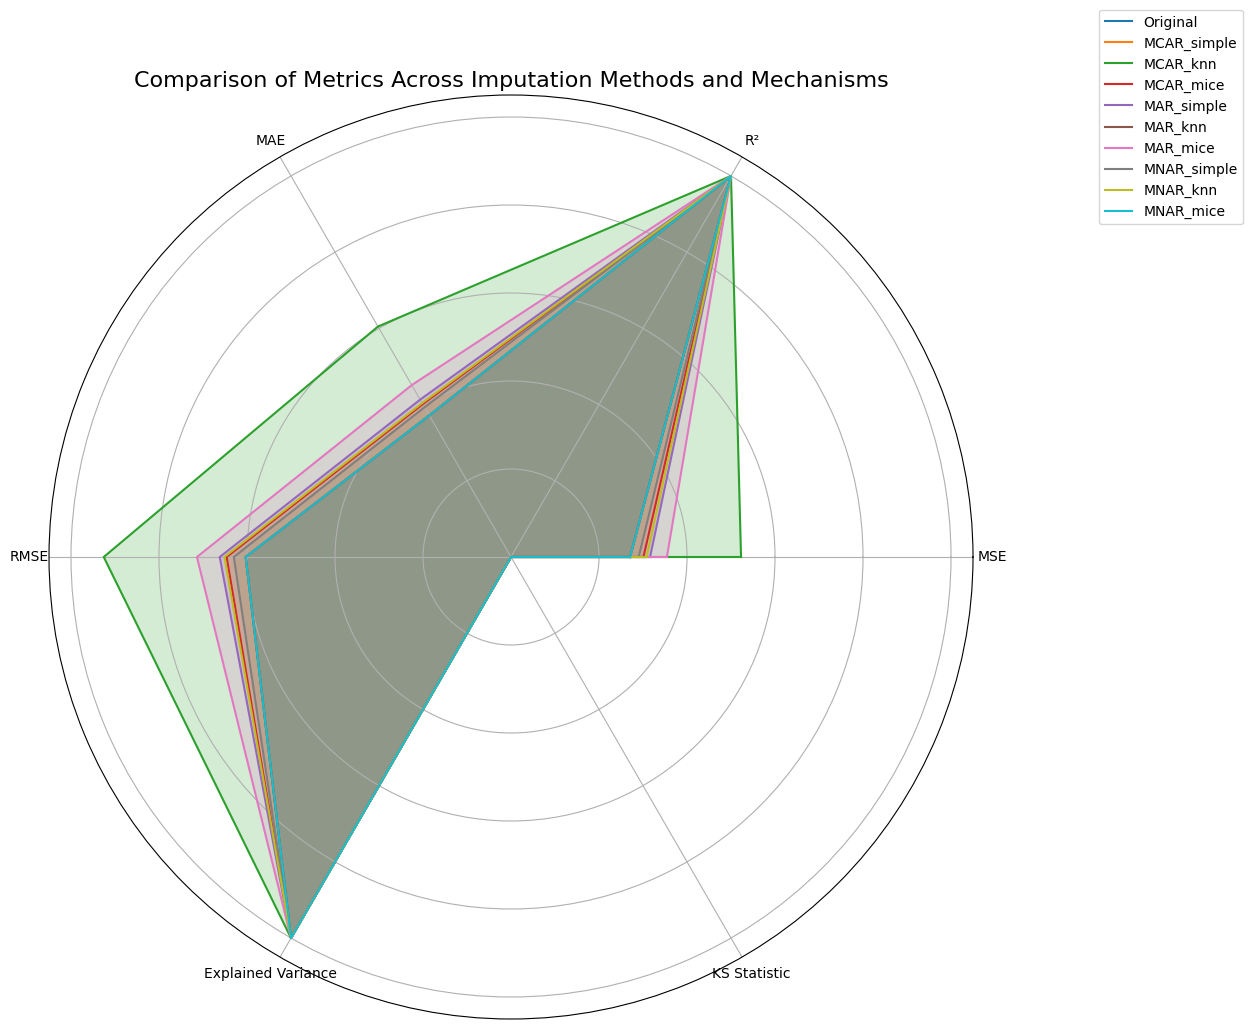

In [42]:
metrics = ['MSE', 'R²', 'MAE', 'RMSE', 'Explained Variance', 'KS Statistic']

scaler = MinMaxScaler()
normalized_metrics = scaler.fit_transform([
    mse_values, r2_values, mae_values, rmse_values, explained_variance_values, ks_values
]).T

def radar_plot(metrics, dataset_names, data):
    num_metrics = len(metrics)
    angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
    angles += angles[:1]  

    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))
    
    for i, dataset in enumerate(dataset_names):
        values = data[i].tolist()
        values += values[:1] 
        ax.plot(angles, values, label=dataset)
        ax.fill(angles, values, alpha=0.2)
    
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics)
    ax.set_title('Comparison of Metrics Across Imputation Methods and Mechanisms', size=16)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

radar_plot(metrics, dataset_names, normalized_metrics)


**MCAR methods**, particularly **kNN and mice**, **align closely with the original data**, suggesting **higher reliability** under this mechanism. In contrast, **MAR** and especially **MNAR show greater deviations**, highlighting the challenges of imputing data when missingness is not random. Overall, **kNN and mice methods outperform simple imputation** in most metrics, with RMSE, MSE, and MAE showing the greatest sensitivity to the choice of method. **R² and Explained Variance** exhibit less variability, indicating they **are less influenced** by the imputation strategy.

### **"Do the results vary depending on the missing mechanism?"**

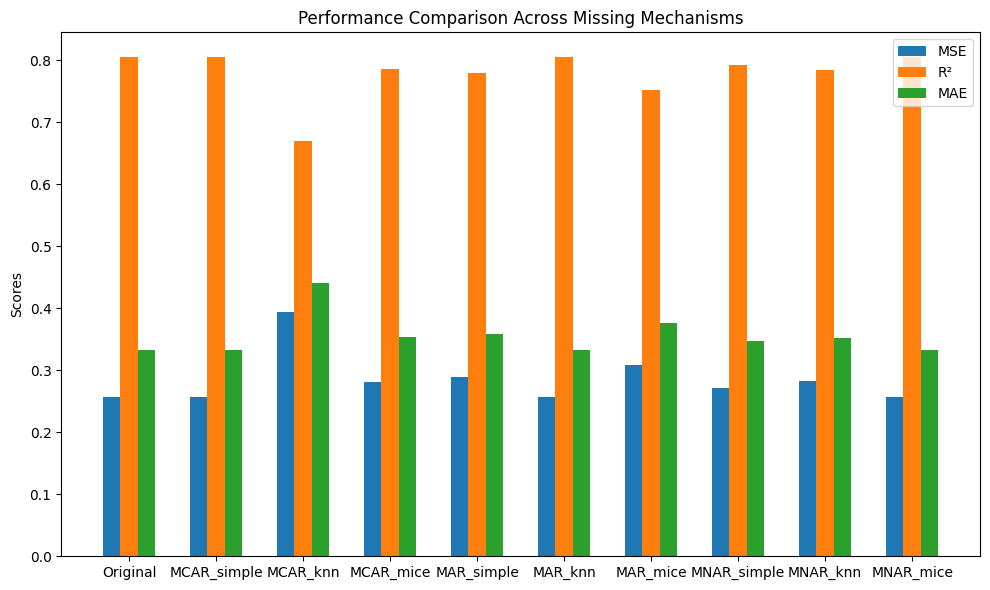

In [ ]:
x = np.arange(len(dataset_names))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - width, mse_values, width, label='MSE')
ax.bar(x, r2_values, width, label='R²')
ax.bar(x + width, mae_values, width, label='MAE')

ax.set_ylabel('Scores')
ax.set_title('Performance Comparison Across Missing Mechanisms')
ax.set_xticks(x)
ax.set_xticklabels(dataset_names)
ax.legend()

plt.tight_layout()
plt.show()

**MCAR performs the worst**, with consistently higher MSE and MAE and lower R² compared to MAR and MNAR. This suggests that the randomness of MCAR provides fewer patterns for effective imputation.

**MAR and MNAR show more similar performance**, with **MNAR performing slightly better** overall. Both mechanisms yield lower errors (MSE and MAE) and higher R² compared to MCAR, indicating that the structured missingness in MAR and MNAR provides better opportunities for imputations to align with the original data. 

### **"Is the top performer in terms of classification metrics also the top performer if the focus shifts towards Predictive or Distributional Accuracy?"**

Once a regression task is being used, this question was adapted to:

### **""Is the top performer in terms of error metrics (MSE, MAE) also the top performer in terms of predictive performance (R², Explained Variance) and distributional accuracy (KS Statistic)?""**

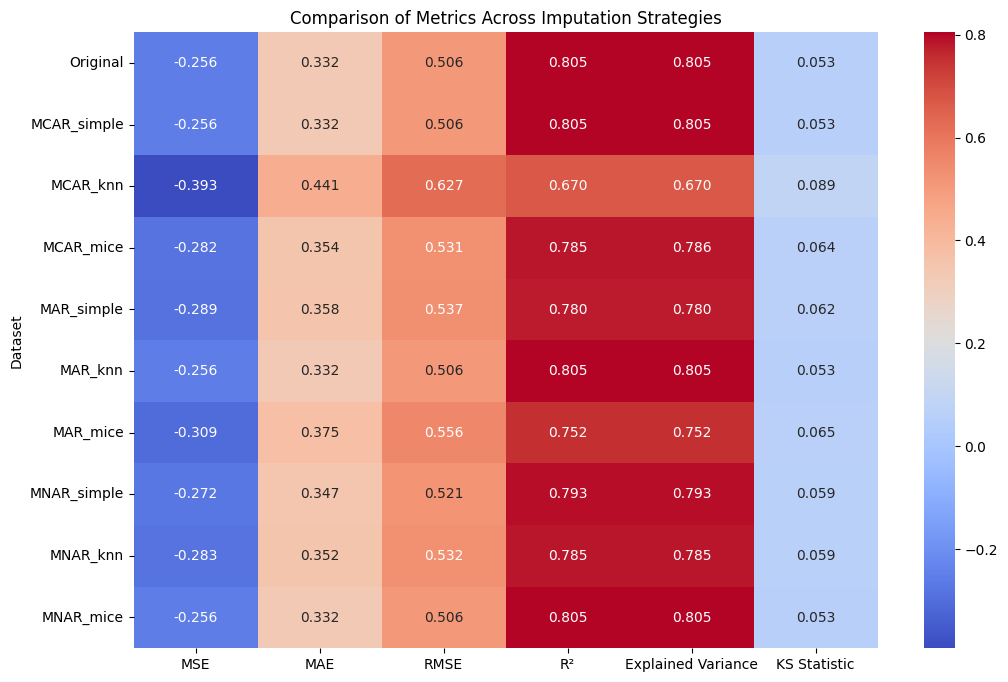

In [ ]:
results_df = pd.DataFrame({
    'Dataset': dataset_names,
    'MSE': mse_values,
    'MAE': mae_values,
    'RMSE': rmse_values,
    'R²': r2_values,
    'Explained Variance': explained_variance_values,
    'KS Statistic': ks_values
}).set_index('Dataset')

results_df_normalized = results_df.copy()
results_df_normalized['MSE'] = -results_df_normalized['MSE'] 

plt.figure(figsize=(12, 8))
sns.heatmap(results_df_normalized, annot=True, cmap='coolwarm', fmt='.3f')
plt.title('Comparison of Metrics Across Imputation Strategies')
plt.show()

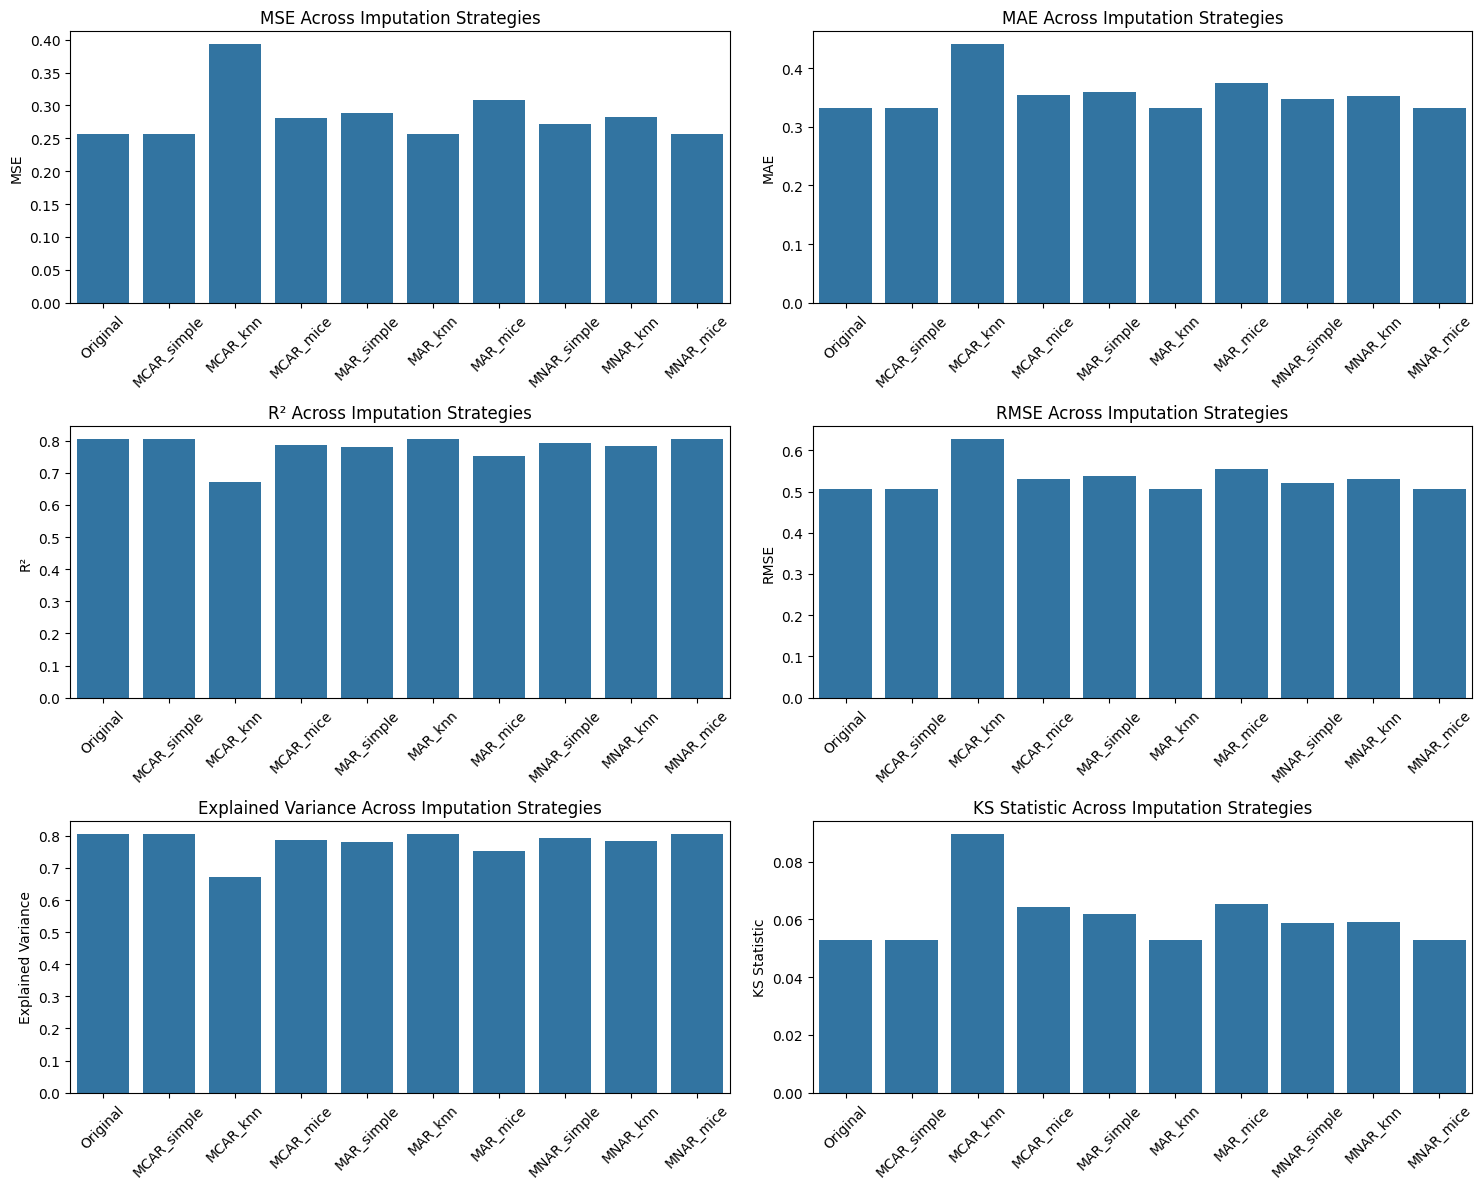

In [45]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

metrics = ['MSE', 'MAE', 'R²', 'RMSE', 'Explained Variance', 'KS Statistic']
for ax, metric in zip(axes.flatten(), metrics):
    sns.barplot(x=dataset_names, y=results_df[metric], ax=ax)
    ax.set_title(f'{metric} Across Imputation Strategies')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

**In terms of error metrics (MSE, MAE, RMSE), the Original dataset and datasets imputed using SimpleImputer (mean strategy) or KNNImputer generally exhibit the best performance, maintaining lower error values.** These methods effectively preserve the underlying structure of the data. MICE (Multiple Imputation by Chained Equations), while slightly worse on these metrics, remains competitive. **MCAR_knn, however, consistently shows the highest error metrics, indicating that KNN imputation struggles in scenarios where data is Missing Completely at Random (MCAR), likely due to insufficient context from neighboring data points.**

In terms of predictive metrics like R² and Explained Variance, similar patterns emerge. **The Original dataset, SimpleImputer, and KNNImputer (for MAR and MNAR conditions) deliver the best performance, with values close to 0.8.** MICE, though slightly behind, still provides reasonable predictive power. However, **MCAR_knn again underperforms significantly, with lower R² and Explained Variance values, reflecting its inability to accurately reconstruct the data's relationships.**

When examining distributional accuracy through the KS Statistic, the results are more nuanced. **SimpleImputer and KNNImputer achieve low KS values, maintaining good fidelity to the original data distribution.** MICE, while maintaining strong predictive performance, shows slightly higher KS values, indicating minor deviations from the true distribution. **Overall, SimpleImputer and KNNImputer emerge as the most balanced approaches across all metrics, excelling in error metrics, predictive performance, and distributional accuracy.**

Then, it can be concluded that yes, the top performer in terms of error metrics is also the top performer in predictive performance and distributional accuracy. SimpleImputer and KNNImputer consistently excel across all metrics, providing the best balance of low error, high predictive power, and good distributional fidelity.

### **Conclusion**
This study highlighted the importance of tailoring imputation strategies to the specific missing data mechanism. SimpleImputer and KNNImputer were reliable and robust choices across most scenarios, particularly for MAR and MNAR datasets, offering strong performance in all metrics. MICE, while slightly less robust in certain scenarios, remained effective for datasets with structured missingness. MCAR scenarios posed unique challenges for KNNImputer, emphasizing the need for careful method selection. Future research could expand this analysis by exploring the impact of missingness on other machine learning algorithms, such as gradient boosting or neural networks. 